### Some Analysis of the NOAA weather dataset ###

In this notebook we are analyzing a sample out of data that was downloaded from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/, the main file is ghcnd_all.tar.gz which is about 2.4 GB which becomes around 20GB when uncompressed.

The data contains about 1 million station-year recordings. That is too much to analyzer on single core machine, so we start by taking a sample of 20,000 recordings of the maximal daily temperatures for a period of a 365 days starting on January 1st (the last day of leap years is discarded).

### Checking the versions of some important packages ###

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import sklearn as sk
print 'pandas version: ',pd.__version__,'should be at least 0.14.0'
print 'numpy version:',np.__version__,'should be at least 1.8.1'
print 'sklearn version:',sk.__version__,'should be at least 0.14.1'

Populating the interactive namespace from numpy and matplotlib
pandas version:  0.15.2 should be at least 0.14.0
numpy version: 1.8.2 should be at least 1.8.1
sklearn version: 0.15.2 should be at least 0.14.1


Switch to the data directory and check it's contents

In [2]:
%cd ../data/weather/
#%cs ~/data/weather
!ls -lh

/home/sachin/code/git/DSE2015/DSE200-notebooks/data/weather
total 78M
-rw-rw-r-- 1 sachin sachin 839K Oct  2 09:41 ALL.corrupted.csv
-rw-rw-r-- 1 sachin sachin 839K Oct  2 09:41 ALL.head.csv
-rw-rw-r-- 1 sachin sachin  218 Oct  2 09:41 data-source.txt
-rw-rw-r-- 1 sachin sachin  22K Oct  2 09:41 ghcnd-readme.txt
-rw-rw-r-- 1 sachin sachin 7.5M Oct  2 09:41 ghcnd-stations_buffered.txt
-rw-rw-r-- 1 sachin sachin 7.0M Oct  2 09:41 ghcnd-stations.txt
-rw-rw-r-- 1 sachin sachin  270 Oct  2 09:41 ghcnd-version.txt
-rw-rw-r-- 1 sachin sachin  37M Oct  2 09:41 make_covar.raw_256
-rw-rw-r-- 1 sachin sachin  25M Oct  2 09:41 SAMPLE_TMAX.csv
-rw-rw-r-- 1 sachin sachin  13K Oct  2 09:41 TMAX.10.csv
-rw-rw-r-- 1 sachin sachin    0 Oct  2 09:41 TMAX.head.csv


In [3]:
!cat data-source.txt

I got the data from this ftp site:

ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/

Opening the ftp site in a browser is helpful: you can easily browse the directory structure and look at txt and
pdf files.

Yoav Freund


- *data-source.txt* - information about downloading the data from NOAA
- *ghcnd-readme.txt* - A readme file describing the content of all of the files from ghcnd, in particular:
- *ghcnd-stations.txt* - information about each of the meteorological stations.
- *Sample_TMAX_By_Year* - a file with 10,000 randomly selected one-year-long TMAX measurements

In [4]:
!head -1 SAMPLE_TMAX.csv
# a Typical single line in the data file

USC00507570,TMAX,2005,67,44,61,17,-17,-22,-39,-44,-44,-78,-156,-156,-33,28,39,22,-89,-139,-156,44,61,50,-39,17,67,61,-61,-61,11,33,-72,-100,-150,-178,-150,-33,39,28,22,11,-150,-156,-150,50,44,28,39,50,56,39,67,50,39,56,50,56,44,22,6,17,17,61,83,67,67,89,78,61,61,83,56,44,67,89,67,89,100,83,56,17,22,50,39,28,-6,28,-6,-28,-50,-44,-33,-22,-22,-22,17,67,67,78,94,89,72,56,89,111,94,83,56,11,28,56,89,133,133,128,178,167,194,211,189,178,161,172,144,133,128,117,183,200,211,211,178,172,133,150,128,133,150,150,178,211,200,133,172,144,161,156,139,150,133,144,161,150,161,200,183,228,222,183,144,150,178,167,183,239,239,267,244,222,222,117,189,233,194,206,261,228,211,222,261,228,228,200,194,183,233,244,217,267,250,217,161,200,200,194,250,261,222,194,183,161,206,228,228,222,206,200,167,183,194,172,200,189,167,183,194,200,206,217,206,244,267,256,278,294,278,256,228,228,189,206,211,211,161,156,144,156,161,156,167,139,122,144,139,156,150,144,128,144,128,150,150,133,144,172,156,106,161,161,122,122,133,11

### read data into a Pandas Dataframe ##
* Read the data into a DataFrame
* Read the data vectors in G
* Divide by 10.0 to get the temperatude in degrees celsius
* Replace values outside the range [-400,500]  ([-40,50] degrees celsius) with nan  
* Paste fixed matrix back into Dout
* Show the first few lines of DDout

In [5]:
header=['station','measurement','year']+range(1,366)
# D=pandas.DataFrame(columns=header)
Data = pd.read_csv('SAMPLE_TMAX.csv',header=None,names=header)
G=Data.ix[:,1:365]
G[G<-400]=np.nan   #remove outliers
G[G>500]=np.nan
G=G/10   # temp / 10 is the temp in celsius
Data.ix[:,1:365]=G
G=G.transpose()
Data.head()

,station,measurement,year,1,2,3,4,5,6,7,...,356,357,358,359,360,361,362,363,364,365
0,USC00507570,TMAX,2005,6.7,4.4,6.1,1.7,-1.7,-2.2,-3.9,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,NOE00135018,TMAX,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.8,3.1,4.5,4.2,3.2,1.6,2.0,2.2,3.9,6.1
2,KZ000036546,TMAX,1982,NaN,NaN,-13.9,NaN,NaN,-4.5,NaN,...,NaN,-7.3,NaN,NaN,NaN,-17.0,-16.6,-16.0,-13.5,-9.9
3,USC00054664,TMAX,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.4,7.8,3.3,NaN,NaN,3.9,5.6,-3.9,-15.0,-15.0
4,CUW00011706,TMAX,1981,30.0,28.3,30.0,30.0,28.3,28.9,28.9,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1


In [32]:
shape(Data)

(20000, 368)

(7300000,) <class 'pandas.core.series.Series'>
-40.0 50.0


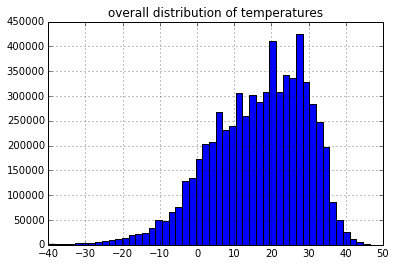

In [6]:
tmp=G.ix[:,:].unstack()
print tmp.shape, type(tmp)
tmp.hist(bins=50);
title('overall distribution of temperatures')
print tmp.min(),tmp.max()

### Script for plotting yearly plots ###

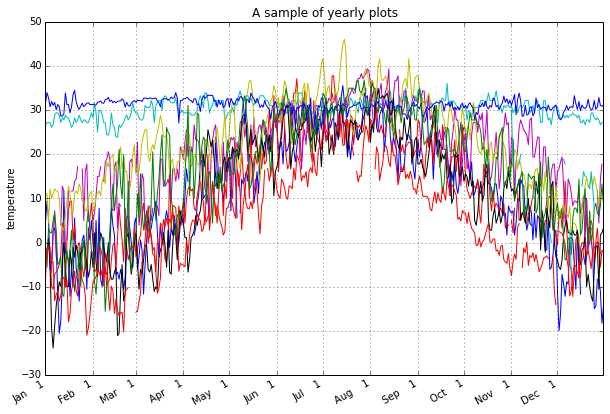

In [7]:
from datetime import date
dates=[date.fromordinal(i) for i in range(1,366)]
def YearlyPlots(T,ttl='',size=(10,7)):
    fig=plt.figure(1,figsize=size,dpi=300)
    #fig, ax = plt.subplots(1)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    plot(dates,T);
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    ylabel('temperature')
    grid()
    title(ttl)
YearlyPlots(Data.ix[20:30,1:365].transpose(),ttl='A sample of yearly plots')

### Plots for sydney, Australia ###

['ASN00066124' 'ASN00066059' 'ASN00066194' 'ASN00066131' 'ASN00066195'
 'ASN00066062']


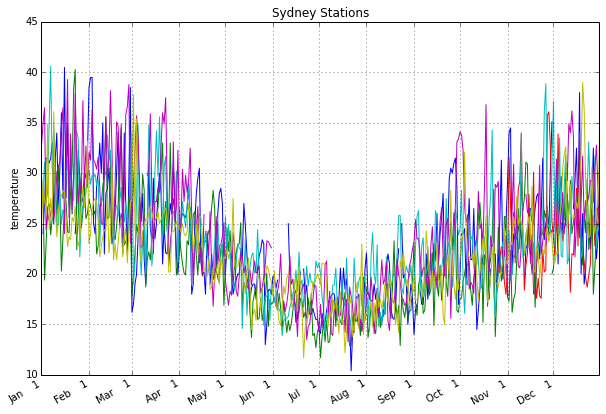

In [8]:
sydneyStations=['ASN00066' in station for station in Data['station']]
print Data[sydneyStations]['station'].values
#for station in sydneyStations:
#    print station,sum(Data['station']==station)
tmp=Data[sydneyStations].transpose()
YearlyPlots(tmp.ix[1:365,:],ttl='Sydney Stations')
#tmp.ix[:,tmp.columns[7]]
#Data[sydneyStations][['station','year']]

### Computing mean and std for each station/year ###
And calculating the standard deviation. In this case we are not divi

In [9]:
# a simple scale function to normalize the data-frame row-by-row
from numpy import mean, std
def scale_temps(Din):
    matrix=Din.iloc[:,3:]
    Dout=Din.loc[:,['station','year']+range(1,366)]
    Mean=mean(matrix, axis=1).values
    Dout['Mean']=Mean
    Std= std(matrix, axis=1).values
    Dout['Std']=Std
    # Decided not to normalize each year to have mean zero and std 1
    # tmp = pd.DataFrame((matrix.values - Mean[:,np.newaxis])/Std[:,newaxis],columns=range(1,366))
    # print tmp.head()
    Dout.loc[:,1:365]=matrix.values
    return Dout
Dout=scale_temps(Data)
#reorder the columns
Dout=Dout[['station','year','Mean','Std']+range(1,366)]
Dout.head()

,station,year,Mean,Std,1,2,3,4,5,6,...,356,357,358,359,360,361,362,363,364,365
0,USC00507570,2005,8.531507,10.439819,6.7,4.4,6.1,1.7,-1.7,-2.2,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,NOE00135018,1959,14.494545,7.974400,NaN,NaN,NaN,NaN,NaN,NaN,...,5.8,3.1,4.5,4.2,3.2,1.6,2.0,2.2,3.9,6.1
2,KZ000036546,1982,7.220513,14.897310,NaN,NaN,-13.9,NaN,NaN,-4.5,...,NaN,-7.3,NaN,NaN,NaN,-17.0,-16.6,-16.0,-13.5,-9.9
3,USC00054664,1964,18.576860,10.790115,NaN,NaN,NaN,NaN,NaN,NaN,...,9.4,7.8,3.3,NaN,NaN,3.9,5.6,-3.9,-15.0,-15.0
4,CUW00011706,1981,31.321370,1.588618,30.0,28.3,30.0,30.0,28.3,28.9,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1


### Compute average temperature for each day of the year. ###

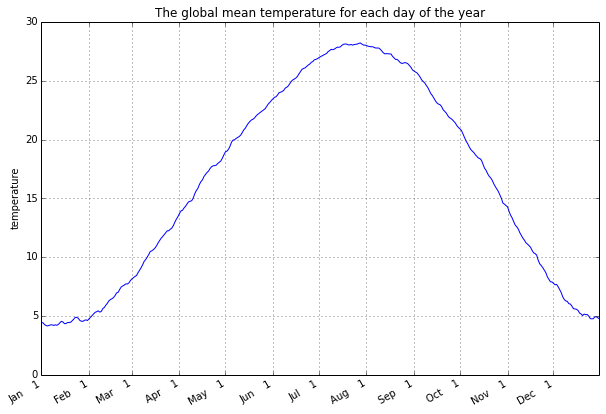

In [10]:
Mean=mean(Dout.ix[:,1:365], axis=0)
YearlyPlots(Mean,ttl='The global mean temperature for each day of the year')


##Principle Component Analysis##
An explanation of the principle component analysis (PCA) can be found
in [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis).
The site [setosa.io](http://setosa.io/ev/principal-component-analysis/) contains a nice interactive visualization of PCA.

In this section we use PCA to model the main ways in which temperarature along the year varies between stations.   We start by cleaning the data.

### Missing Values ###
We find the distribution of missing values and decide how to deal with them. From the analysis below we see that most rows have some
missing values. We therefor choose to perform the average more carefully, rather than discard rows with many missing values

3783

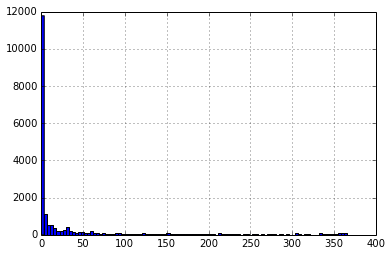

In [11]:
nan_per_row=sum(isnan(Dout.ix[:,1:365]),axis=1)
nan_per_row.hist(bins=100)
sum(nan_per_row>50)

### NaN-tolerant averaging  ###
We compute the empirical covariance matrix in a way that tolerates NaN values.

<span style="color:red"> In the code below I remove all rows that have a nan in them. If you remve the command **M.dropna(...** then all rows are used. Can you get better results without removing the rows? </span>

In [12]:
M=Dout.loc[:,1:365]
M=M.dropna(axis=0)
(columns,rows)=shape(M)
Mean=mean(M, axis=0).values

print (columns,rows), shape(Mean)
C=np.zeros([columns,columns])   # Sum
N=np.zeros([columns,columns])   # Counter of non-nan entries
print shape(M)

(8866, 365) (365,)
(8866, 365)


In [13]:
from sklearn.decomposition import PCA
K=5
pca = PCA(n_components=K)
pca.fit(M)
T=pca.transform(M)

In [14]:
T.shape

(8866, 5)

In [15]:
shape(pca.components_)

(5, 365)

### Percentage of variance Explained ###

[ 0.61442763  0.10915681  0.01191524  0.00946922  0.00693509]


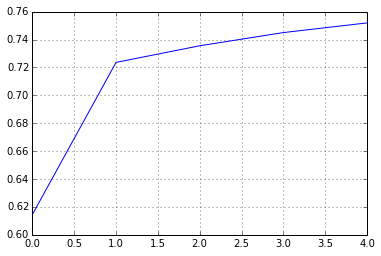

In [16]:
cumulative_explained = cumsum(pca.explained_variance_ratio_) 
plot(cumulative_explained);
#xlim([0,365])
grid()

print pca.explained_variance_ratio_[:10]


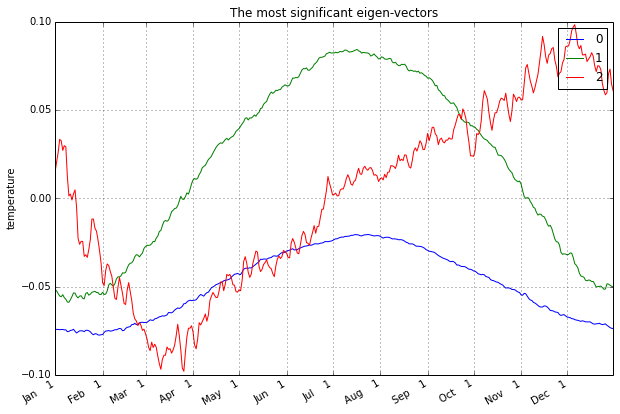

In [17]:
k=3 # number of components to show.
Tcomp=np.transpose(pca.components_)
YearlyPlots(Tcomp[:,:k],ttl='The most significant eigen-vectors')
legend(range(0,k));

In [18]:
k=5
Eig=np.matrix(Tcomp[:,:k])
#print [np.linalg.norm(U[:,i]) for i in range(k)]
matrix=np.matrix(Dout.ix[:,1:365])-Mean
matrix[isnan(matrix)]=0
print shape(Eig),shape(matrix)
Prod=matrix*Eig;
print shape(Prod)

(365, 5) (20000, 365)
(20000, 5)


Insert coefficients for k top eigenvectors into the dataframe **Dout**

In [19]:
for i in range(k-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=Dout.index)
    Dout.insert(4,'V'+str(i),Ser)
Dout.head()

,station,year,Mean,Std,V0,V1,V2,V3,V4,1,...,356,357,358,359,360,361,362,363,364,365
0,USC00507570,2005,8.531507,10.439819,142.481893,-52.954486,-33.906654,1.390382,-26.534812,6.7,...,-3.9,-3.3,-1.7,3.9,6.1,5.0,6.1,6.1,4.4,6.1
1,NOE00135018,1959,14.494545,7.974400,57.593976,-51.171107,-21.458607,-18.718011,0.623031,NaN,...,5.8,3.1,4.5,4.2,3.2,1.6,2.0,2.2,3.9,6.1
2,KZ000036546,1982,7.220513,14.897310,56.464932,27.415070,-7.181212,4.198383,2.694539,NaN,...,NaN,-7.3,NaN,NaN,NaN,-17.0,-16.6,-16.0,-13.5,-9.9
3,USC00054664,1964,18.576860,10.790115,23.514882,11.358559,-23.872717,-20.950578,6.612579,NaN,...,9.4,7.8,3.3,NaN,NaN,3.9,5.6,-3.9,-15.0,-15.0
4,CUW00011706,1981,31.321370,1.588618,-314.692267,-25.150375,9.395788,5.844722,-4.984370,30.0,...,30.0,31.1,32.2,31.1,31.1,32.2,32.2,31.1,31.1,31.1


### Longitude,Latitude information ###
Loading the station longitude/latitude and merging it into the Table

In [20]:
!ls

ALL.corrupted.csv  data-source.txt   ghcnd-stations_buffered.txt  ghcnd-version.txt   SAMPLE_TMAX.csv  TMAX.head.csv
ALL.head.csv	   ghcnd-readme.txt  ghcnd-stations.txt		  make_covar.raw_256  TMAX.10.csv


In [21]:
!cat ghcnd-readme.txt   # uncomment to read the readme file.

README FILE FOR DAILY GLOBAL HISTORICAL CLIMATOLOGY NETWORK (GHCN-DAILY) 
Version 3.00

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

I. DOWNLOAD QUICK START

Start by downloading "ghcnd-stations.txt," which has metadata for all stations.

Then download one of the following TAR files:

  - "ghcnd-all.tar.gz" if you want all of GHCN-Daily, OR
  - "ghcnd-gsn.tar.gz" if you only want the GCOS Surface Network (GSN), OR
  - "ghcnd-hcn.tar.gz" if you only want the U.S. Historical Climatology Network 
    (U.S. HCN).

Then uncompress and untar the contents of the tar file, 
e.g., by using the following Linux command:

tar xzvf ghcnd_xxx.tar.gz

Where "xxx" stands for "all", "hcn", or "gsn" as applicable. The files will be 
extracted into a subdirectory under the directory where the command is issued.

ALTERNATIVELY, if you only need data for one station:

  - Find the station's

In [22]:
# Make all lines be of length 90 to solve problem wilth read_fwf
out=open('ghcnd-stations_buffered.txt','w')
for line in open('ghcnd-stations.txt','r').readlines():
    line=line.rstrip()
    string=line+' '*(90-len(line))+'\n'
    out.write(string)
out.close()

In [23]:
colspecs = [(0, 11), (11, 21), (21, 31), (31, 38),(39,41),(41,72),(72,76),(76,80),(80,86)]
stations = pd.read_fwf('ghcnd-stations_buffered.txt', colspecs=colspecs, header=None, index_col=0,
                       names=['latitude','longitude','elevation','state','name','GSNFLAG','HCNFLAG','WMOID'])

In [24]:
#stations['elevation'][stations['elevation']==-999.9]=0  # decided not to remove -999.9 because this confuses hist

In [25]:
print stations.shape
stations.head()

(85284, 8)


,latitude,longitude,elevation,state,name,GSNFLAG,HCNFLAG,WMOID
ACW00011604,17.1167,-61.7833,10.1,NaN,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,NaN,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196
AF000040930,35.3170,69.0170,3366.0,NaN,NORTH-SALANG,GSN,NaN,40930
AG000060390,36.7167,3.2500,24.0,NaN,ALGER-DAR EL BEIDA,GSN,NaN,60390


### perform a **JOIN** ###
Join the geographical information into **Dout**, creating a new dataframe called **Djoined**

In [26]:
Djoined=Dout.join(stations,on='station')

In [27]:
Djoined.columns[-10:]

Index([364, 365, u'latitude', u'longitude', u'elevation', u'state', u'name', u'GSNFLAG', u'HCNFLAG', u'WMOID'], dtype='object')

In [28]:
Djoined['AbsLatitude']=abs(Djoined['latitude'].values)

In [29]:
Djoined.ix[:5,['station',u'longitude','latitude',u'AbsLatitude','Mean','Std','V0','V1','V2']]

,station,longitude,latitude,AbsLatitude,Mean,Std,V0,V1,V2
0,USC00507570,-154.3164,60.2036,60.2036,8.531507,10.439819,142.481893,-52.954486,-33.906654
1,NOE00135018,10.3481,59.2300,59.2300,14.494545,7.974400,57.593976,-51.171107,-21.458607
2,KZ000036546,83.6830,48.5500,48.5500,7.220513,14.897310,56.464932,27.415070,-7.181212
3,USC00054664,-106.3681,40.0575,40.0575,18.576860,10.790115,23.514882,11.358559,-23.872717
4,CUW00011706,-75.1500,19.9000,19.9000,31.321370,1.588618,-314.692267,-25.150375,9.395788
5,KG000036982,78.2330,41.8830,41.8830,-12.500000,2.500000,2.583140,1.701492,-2.610502


### Looking for significant correlations and dependencies ###

In [34]:
Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4']].cov()

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4
latitude,357.338215,610.684430,-84.563827,32.995352,1677.110745,490.487718,3.894549,-47.114093,-16.377163
elevation,610.684430,402304.438251,-553.680558,147.390961,10074.869350,295.360309,-870.066289,-2576.703177,894.432121
Mean,-84.563827,-553.680558,61.433472,-12.770270,-941.192271,52.100901,3.614234,5.444206,4.957587
Std,32.995352,147.390961,-12.770270,10.885685,294.079400,85.942955,-3.992569,-0.456268,-2.519408
V0,1677.110745,10074.869350,-941.192271,294.079400,18130.395583,119.263114,-7.069433,-115.150954,-108.714807
V1,490.487718,295.360309,52.100901,85.942955,119.263114,3193.165902,13.903190,20.520656,-13.370889
V2,3.894549,-870.066289,3.614234,-3.992569,-7.069433,13.903190,553.284374,79.899477,3.477208
V3,-47.114093,-2576.703177,5.444206,-0.456268,-115.150954,20.520656,79.899477,368.272027,5.695783
V4,-16.377163,894.432121,4.957587,-2.519408,-108.714807,-13.370889,3.477208,5.695783,241.268316


<span style="color:red"> The correlations between different $V_i$ components should be zero, which it isn't.
Is this due to numerical roundoff errors? Are the correlations statistically significant for this sample size? </span>

In [35]:
Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4']].corr()

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4
latitude,1.000000,0.050933,-0.570855,0.529138,0.658898,0.459174,0.008759,-0.129875,-0.055776
elevation,0.050933,1.000000,-0.111377,0.070434,0.117966,0.008241,-0.058318,-0.211691,0.090786
Mean,-0.570855,-0.111377,1.000000,-0.493821,-0.891743,0.117625,0.019602,0.036192,0.040718
Std,0.529138,0.070434,-0.493821,1.000000,0.661912,0.460934,-0.051442,-0.007206,-0.049157
V0,0.658898,0.117966,-0.891743,0.661912,1.000000,0.015674,-0.002232,-0.044564,-0.051980
V1,0.459174,0.008241,0.117625,0.460934,0.015674,1.000000,0.010460,0.018923,-0.015233
V2,0.008759,-0.058318,0.019602,-0.051442,-0.002232,0.010460,1.000000,0.177005,0.009517
V3,-0.129875,-0.211691,0.036192,-0.007206,-0.044564,0.018923,0.177005,1.000000,0.019108
V4,-0.055776,0.090786,0.040718,-0.049157,-0.051980,-0.015233,0.009517,0.019108,1.000000


In [36]:
# Choosing significance threshold so that none of the correlations between the Vi-s are significant.
abs(Djoined[['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4']].corr())>0.2

,latitude,elevation,Mean,Std,V0,V1,V2,V3,V4
latitude,True,False,True,True,True,True,False,False,False
elevation,False,True,False,False,False,False,False,True,False
Mean,True,False,True,True,True,False,False,False,False
Std,True,False,True,True,True,True,False,False,False
V0,True,False,True,True,True,False,False,False,False
V1,True,False,False,True,False,True,False,False,False
V2,False,False,False,False,False,False,True,False,False
V3,False,True,False,False,False,False,False,True,False
V4,False,False,False,False,False,False,False,False,True


In [37]:
# Seems to take enormous amount of time
from pandas.tools.plotting import scatter_matrix

In [38]:
df = Djoined.ix[:,['latitude','elevation','Mean','Std','V0','V1','V2','V3','V4']]

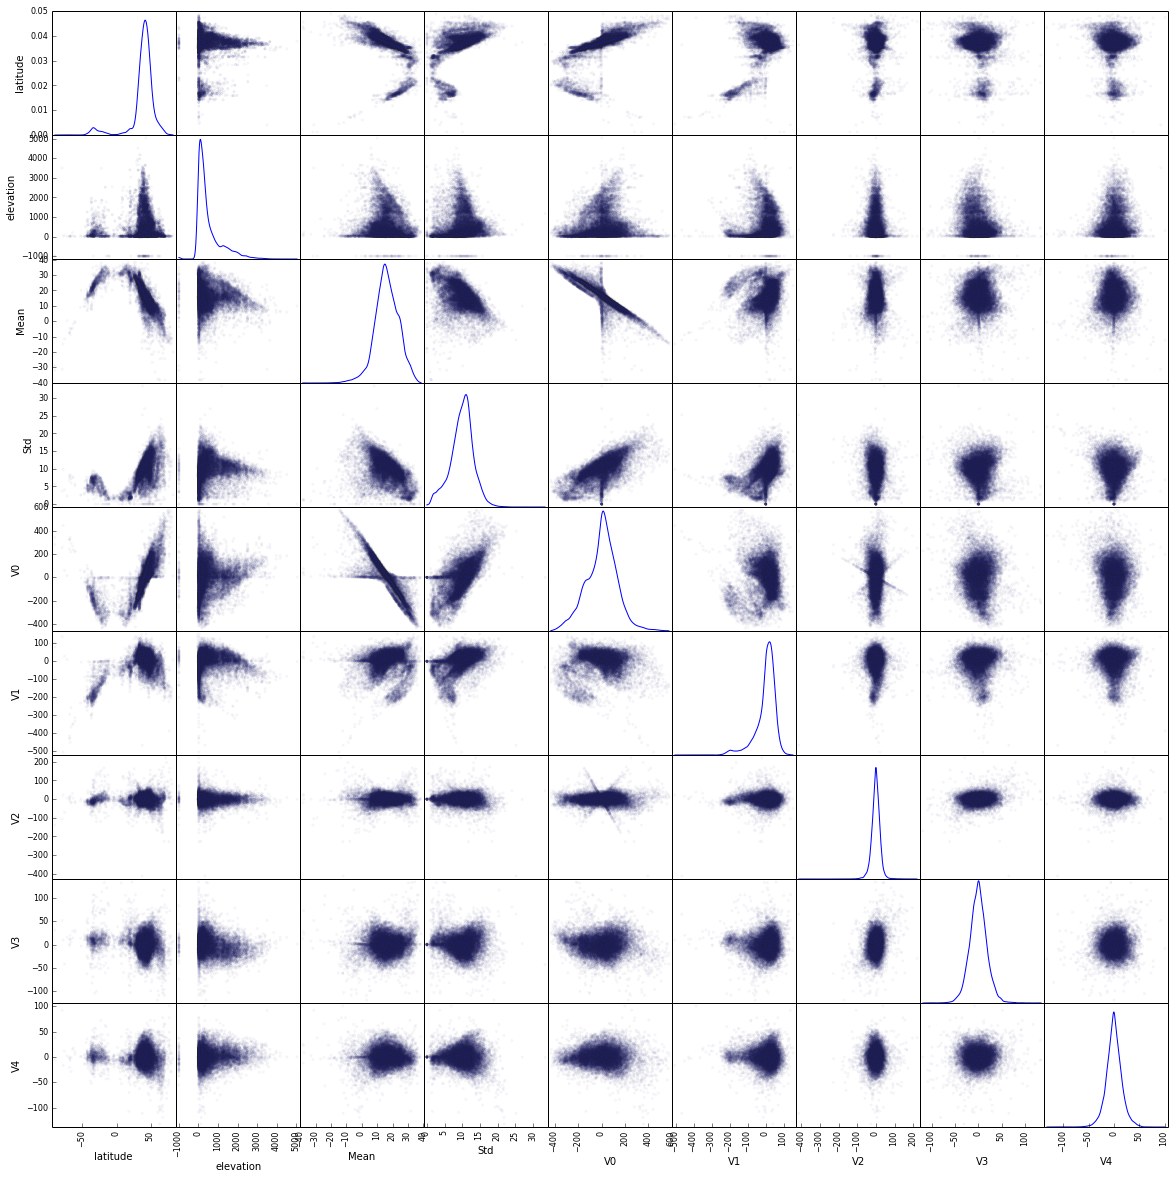

In [39]:
scatter_matrix(df,alpha=0.03, figsize=(20, 20), diagonal='kde');

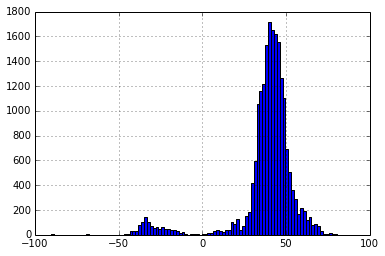

In [40]:
X='latitude'
Djoined.ix[:,X].hist(bins=100);

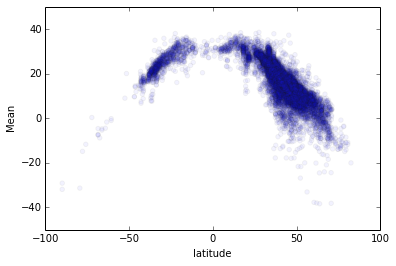

In [41]:
X='latitude';Y='Mean'
scatter(Djoined.loc[:,X],Djoined.loc[:,Y],alpha=0.05)
xlabel(X)
ylabel(Y)

In [42]:
#checking for an anomaly in the elevations of stations
Djoined[['station','elevation']][Djoined['elevation']<-500].head()

,station,elevation
1244,USC00301010,-999.9
1312,USC00095231,-999.9
1747,RSM00023707,-999.9
1821,BL000085041,-999.9
2192,USC00107878,-999.9


In [43]:
!grep ASN00010865 ghcnd-stations.txt

ASN00010865 -34.0333  117.2667 -999.9    LUMEAH                                      


### Plotting maps ###
Working through http://matplotlib.org/basemap/

* http://en.wikipedia.org/wiki/Map_projection
* http://matplotlib.org/basemap/users/mapsetup.html

In [44]:
lons=stations.ix[:,'longitude'].values
lats=stations.ix[:,'latitude'].values
station_names=stations.index.values
ll=len(lons)
lonmin=-180;lonmax=180;latsmin=-80;latsmax=80;
select=(lons>lonmin) * (lons<lonmax)*(lats>latsmin)*(lats<latsmax)
print sum(select)
station_names=station_names[select]
lons=lons[select]
lats=lats[select]
print len(lons),len(lats),len(station_names)

85273
85273 85273 85273


In [ ]:
# http://matplotlib.org/basemap/users/merc.html

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# llcrnrlat,llcrnrlon,urcrnrlat,urcrnrlon
# are the lat/lon values of the lower left and upper right corners
# of the map.
# lat_ts is the latitude of true scale.
# resolution = 'i' means use intermediate resolution coastlines.
plt.figure(figsize=(15,10),dpi=300)
m = Basemap(projection='merc',llcrnrlat=latsmin,urcrnrlat=latsmax,\
            llcrnrlon=lonmin,urcrnrlon=lonmax,lat_ts=20,resolution='i')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')

# draw parallels and meridians.
parallels = np.arange(-80,81,10.)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(10.,351.,20.)
m.drawmeridians(meridians,labels=[True,False,False,True])

#m.drawparallels(np.arange(-90.,91.,30.))
#m.drawmeridians(np.arange(-180.,181.,60.))
m.drawmapboundary(fill_color='aqua')

# draw map with markers for locations
x, y = m(lons,lats)
m.plot(x,y,'g.')

plt.title('weather stations')
plt.show()


To get to these coordinate on Google Maps, type the latitude and longitude in decimal in the search box or use:
https://www.google.com/maps/place/72%C2%B018'00.0%22S+170%C2%B013'00.1%22E/@-72.3,170.216694,17z/data=!3m1!4b1!4m2!3m1!1s0x0:0x0

<span style="color:red">HW questions</span>

1. Waiting for somebody to write a script that will do that automatically from python i.e write a script in python return the google maps url when passed with the latitude and longitudinal values of the place
2. Can you create a map where the denity of points is represented as a density map (topographical map)?
3. Can you create a map that would represent, using color, the values of a chosen column (Mean, Std, V0,V1 etc.)? What conclusions can you draw from this map?


### Reconstruction ###

(365, 5) (5, 8866)
<type 'numpy.ndarray'> <type 'numpy.ndarray'>


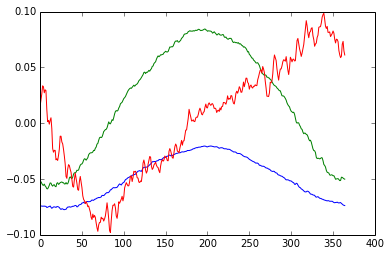

In [47]:
print Eig.shape, T.transpose().shape
Eig=np.array(Eig)
print type(Eig),type(T)
plot(Eig[:,0:3]);

In [79]:
print T.shape[0]

8866


In [49]:
np.prod?

In [73]:
%matplotlib inline
def plot_reconstructions(T,K=10,rows=2,columns=7):
    Recon=np.mat(Eig[:,:K])*np.mat(T[:K,:])+Mean[:,np.newaxis]
    Recon=np.array(Recon)
    #return Recon
    plt.figure(figsize=(columns*3,rows*3),dpi=300)
    j=0;
    for i in range(T.shape[1]):
        subplot(rows,columns,j); 
        j += 1; 
        if j>=rows*columns: break
        plot(Recon[1:,i])
        plot(Djoined.ix[i,1:365]);
        title(Djoined.ix[i,'station']+' / '+str(Djoined.ix[i,'year']))
        xlim([0,365])
        

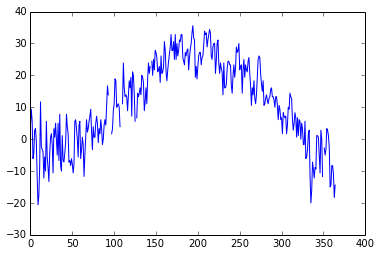

In [74]:
plot(Djoined.ix[20,1:365])

Observe in the reconstructions below that the bloue line fills in (extrapolation/interpolation) the places where the measurements are not available. It also reduces the fluctuations in the relative to the original line. Recall the we are using the k top eigenvectors which explain about 88% of the variance.

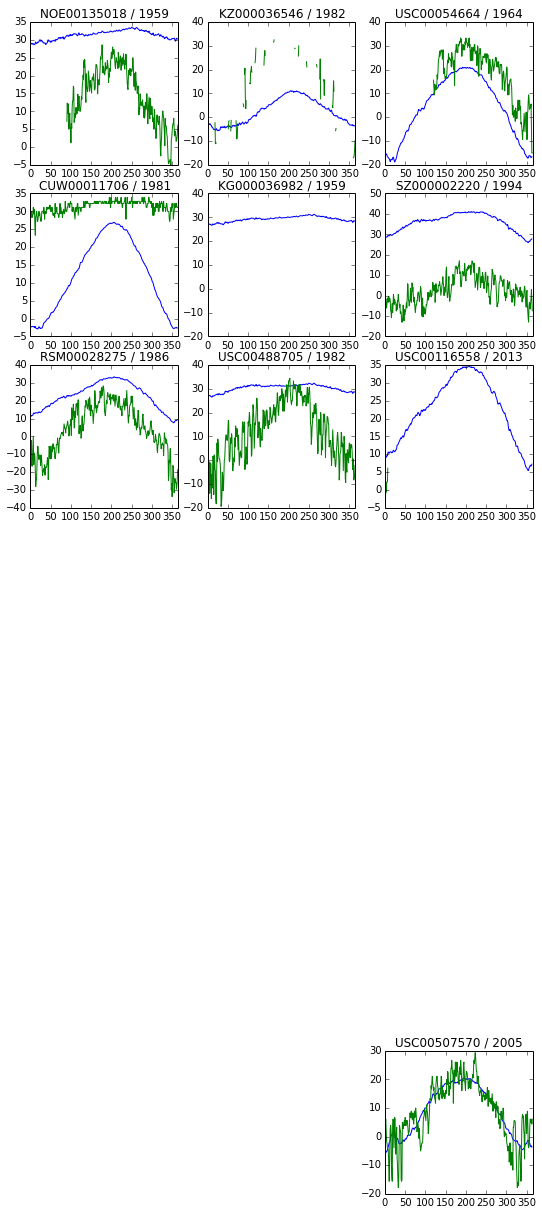

In [77]:
plot_reconstructions(T[:10,:].transpose(),rows=7,columns=3)


<span style="color:red"> Check how the approximations change/improve as you increase the number of coefficients</span>

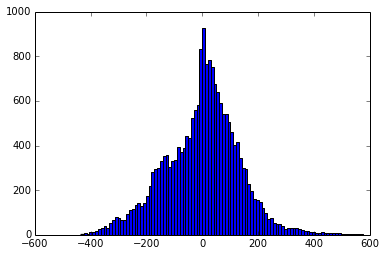

In [53]:
hist(Djoined.ix[:,'V0'],bins=100);

<span style="color:red">Can you reduce the reconstruction error (using a fixed number of eigenvectors) by splitting the stations according to region (for example country, state, latitudal range). Note that having a regions with very few readings defeats the purpose.